## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

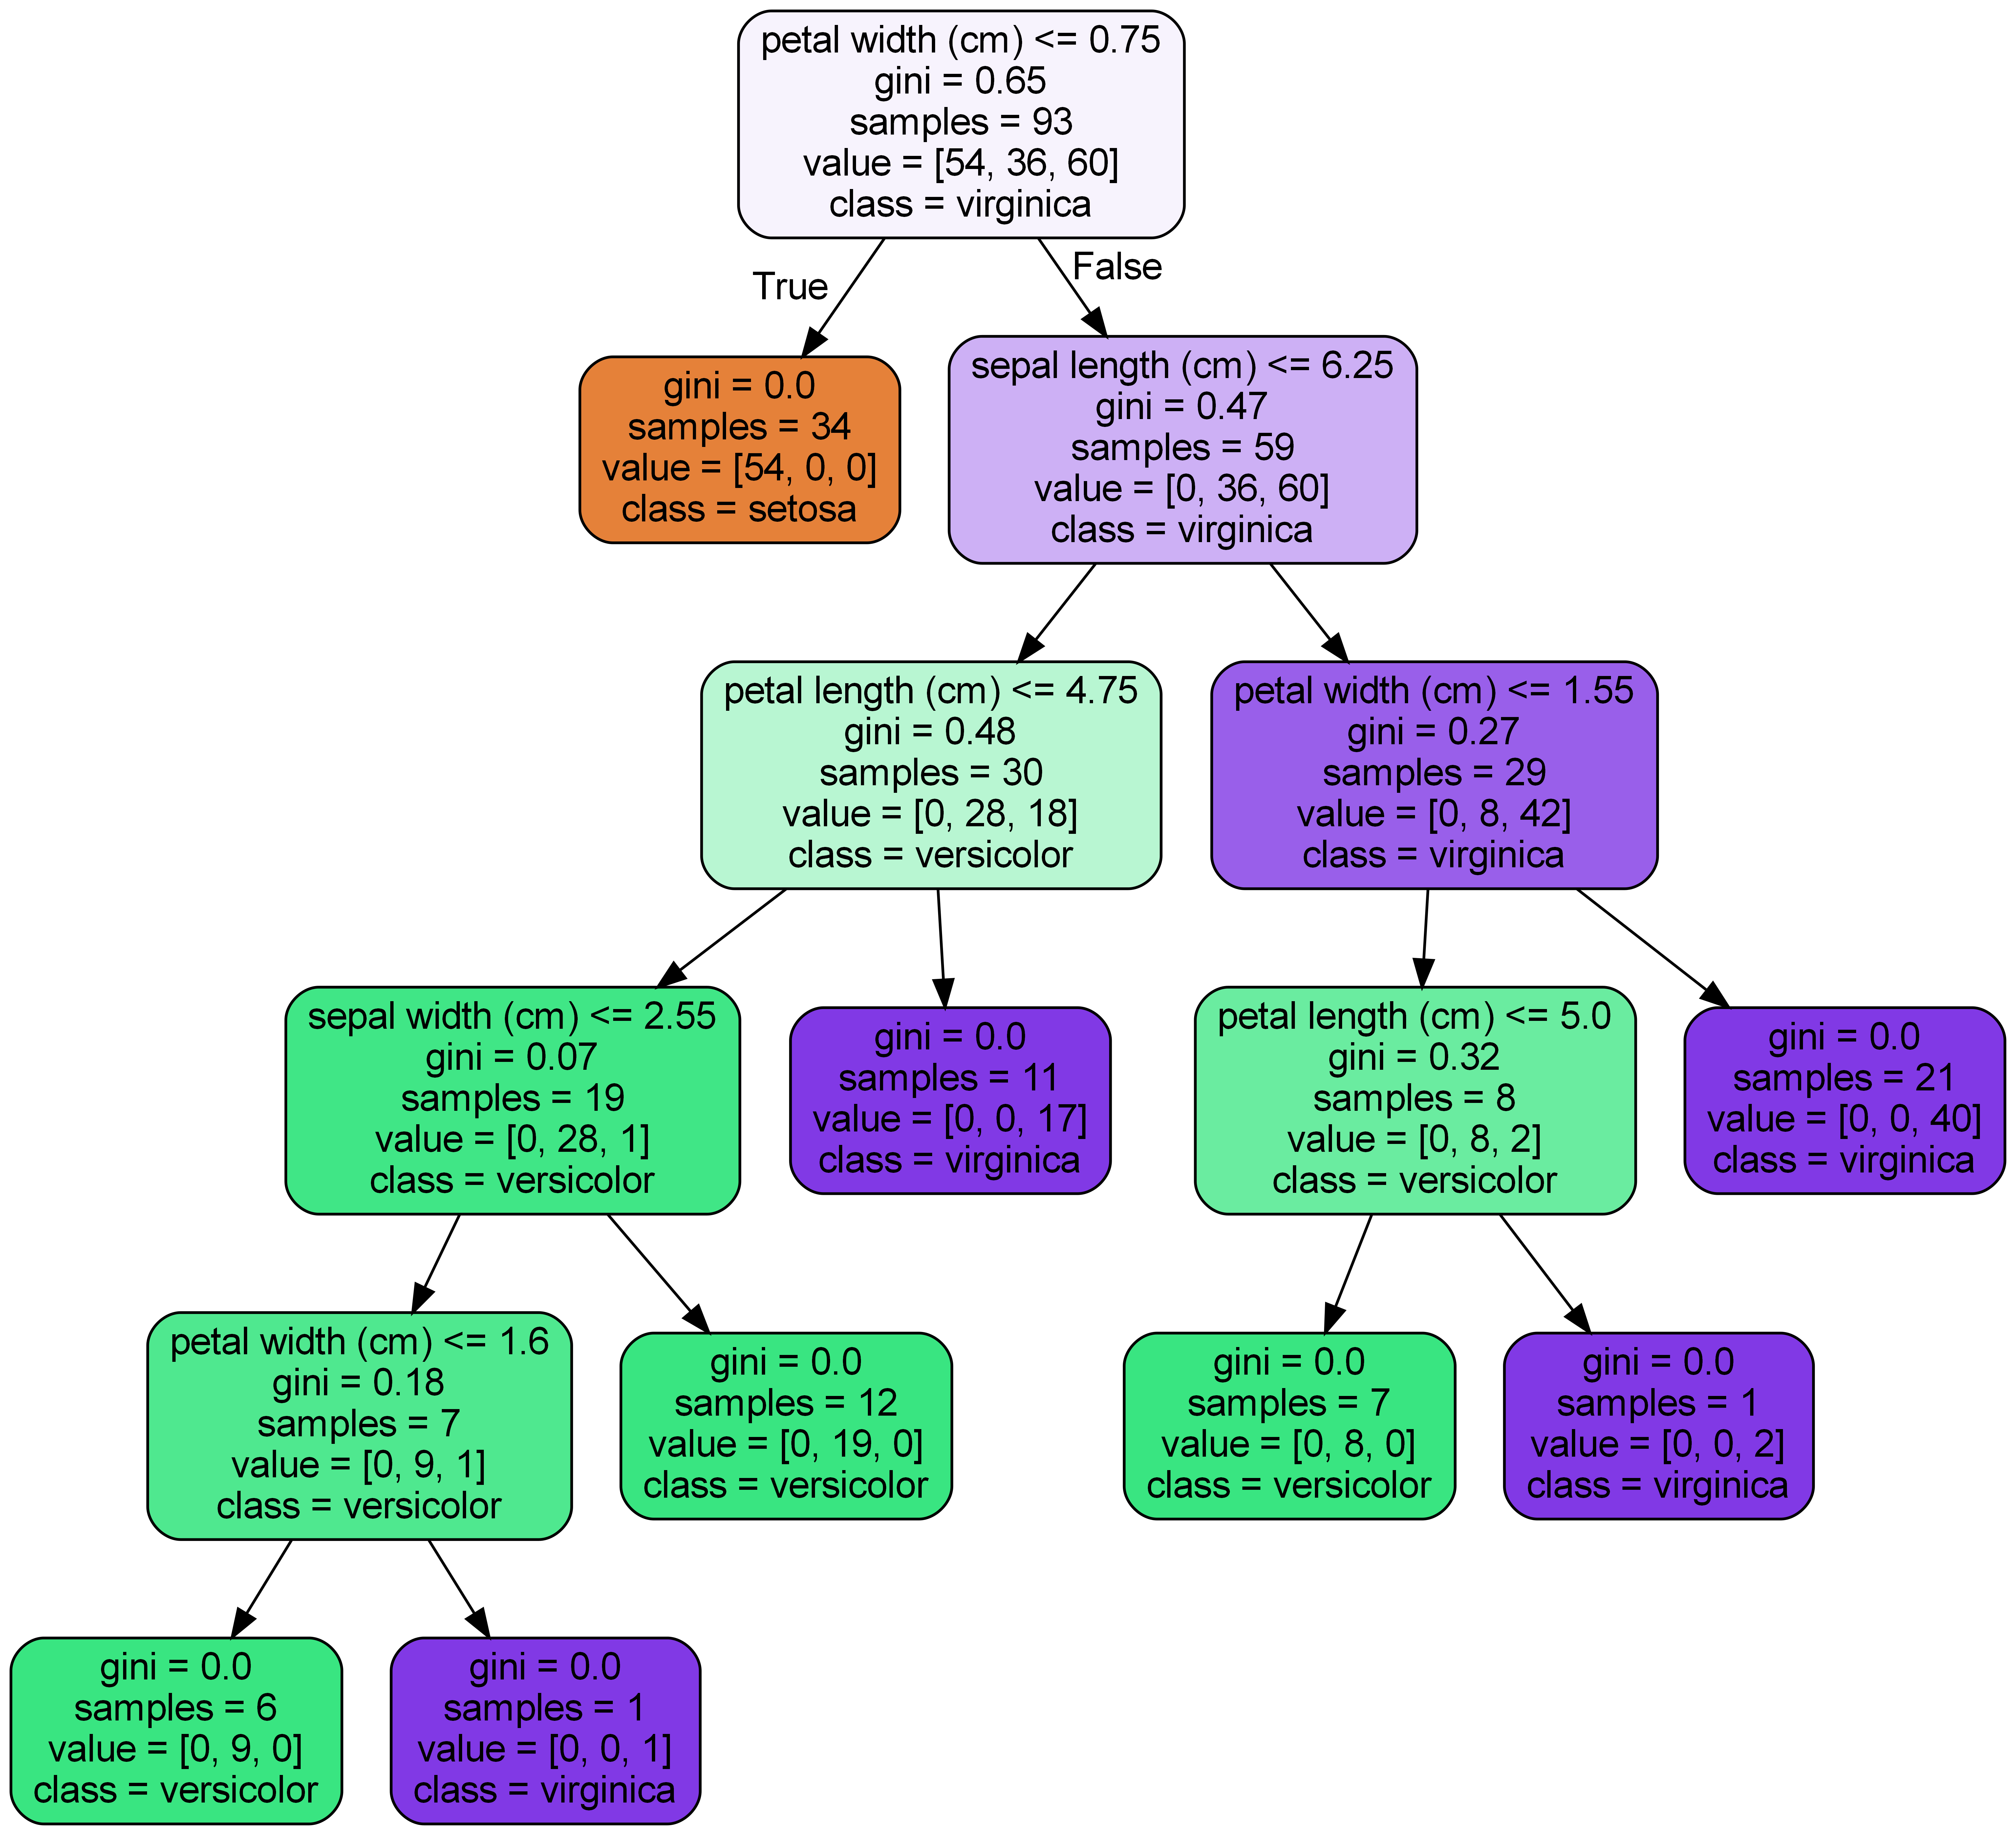

In [441]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [442]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [443]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [444]:
df.shape

(2218, 18)

In [445]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [446]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [447]:
df['n_age'] = 2020 - df['birth_year'].astype('Int64')
df.head()


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,56
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,33
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,56
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,29
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,28


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [448]:
df.isna().sum()

patient_id               0
global_num             904
sex                    145
birth_year             454
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64

In [449]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [450]:
df['disease'].fillna(0, inplace=True)
df.disease = df.disease.replace({True: 1})
df.disease.astype("Int64")

0       0
1       0
2       0
3       0
4       0
       ..
2213    0
2214    0
2215    0
2216    0
2217    0
Name: disease, Length: 2218, dtype: Int64

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [451]:
columns = ['global_num', 'birth_year', 'infection_order', 'infected_by', 'contact_number']

for col in columns:
    df[col].fillna(round(df[col].mean()), inplace=True)


 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [452]:
columns = ['sex', 'age', 'city',
           'infection_case', 'symptom_onset_date',
           'confirmed_date', 'released_date',
           'deceased_date', 'state', 'n_age']

df[columns]

,sex,age,city,infection_case,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,male,50s,Gangseo-gu,overseas inflow,2020-01-22,2020-01-23,2020-02-05,NaN,released,56
1,male,30s,Jungnang-gu,overseas inflow,NaN,2020-01-30,2020-03-02,NaN,released,33
2,male,50s,Jongno-gu,contact with patient,NaN,2020-01-30,2020-02-19,NaN,released,56
3,male,20s,Mapo-gu,overseas inflow,2020-01-26,2020-01-30,2020-02-15,NaN,released,29
4,female,20s,Seongbuk-gu,contact with patient,NaN,2020-01-31,2020-02-24,NaN,released,28
...,...,...,...,...,...,...,...,...,...,...
2213,male,30s,Changwon-si,NaN,NaN,2020-03-16,NaN,NaN,NaN,30
2214,male,20s,Jeju-do,etc,NaN,2020-02-20,NaN,NaN,isolated,22
2215,female,20s,Jeju-do,etc,NaN,2020-02-22,2020-03-07,NaN,released,22
2216,female,40s,etc,etc,NaN,2020-03-02,2020-03-15,NaN,released,48


In [453]:
df.sex.value_counts()

female    1171
male       902
Name: sex, dtype: int64

 **<font color='teal'> Check for any remaining null values.</font>**

In [454]:
# Under the assumption that infections were pseudo-random we can infer that this is reflective of the population and we should therefore
# make a proportional filling of the NaN values.

# Calculate proportions for remaining NaN Values
ratios = df.sex.value_counts(normalize=True)
ratios.iloc[0]

# replace NaN values in sex column with the correct proportion of values
df['sex'] = df['sex'].fillna(pd.Series(np.random.choice(['male', 'female'], 
                                                      p=[ratios.iloc[0], ratios.iloc[1]], size=len(df))))

In [455]:
df.city.describe()

count             2153
unique             134
top       Gyeongsan-si
freq               535
Name: city, dtype: object

In [456]:
df.city.unique()

array(['Gangseo-gu', 'Jungnang-gu', 'Jongno-gu', 'Mapo-gu', 'Seongbuk-gu',
       'etc', 'Songpa-gu', 'Seodaemun-gu', 'Seongdong-gu', 'Seocho-gu',
       'Guro-gu', 'Gangdong-gu', 'Eunpyeong-gu', 'Geumcheon-gu',
       'Gwanak-gu', 'Nowon-gu', 'Dongjak-gu', 'Gangnam-gu',
       'Yangcheon-gu', 'Gwangjin-gu', 'Dongdaemun-gu', 'Yeongdeungpo-gu',
       'Dobong-gu', 'Yongsan-gu', 'Gangbuk-gu', 'Jung-gu', 'Dongnae-gu',
       'Haeundae-gu', 'Yeonje-gu', nan, 'Buk-gu', 'Nam-gu', 'Seo-gu',
       'Geumjeong-gu', 'Saha-gu', 'Suyeong-gu', 'Sasang-gu',
       'Busanjin-gu', 'Dalseo-gu', 'Dalseong-gun', 'Suseong-gu',
       'Dong-gu', 'Wuhan', 'Bupyeong-gu', 'Michuhol-gu', 'Yeonsu-gu',
       'Gyeyang-gu', 'Namdong-gu', 'Yuseong-gu', 'Daedeok-gu', 'Ulju-gun',
       'Sejong', 'Goyang-si', 'Pyeongtaek-si', 'Bucheon-si', 'Suwon-si',
       'Guri-si', 'Siheung-si', 'Gimpo-si', 'Icheon-si', 'Pocheon-si',
       'Anyang-si', 'Yongin-si', 'Paju-si', 'Namyangju-si', 'Seongnam-si',
       'Gwangmyeong-s

In [457]:
df[df['city'] == 'etc']

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
7,1000000008,13.0,male,1992.0,20s,Korea,Seoul,etc,0,overseas inflow,1.0,2.600789e+09,0.0,NaN,2020-02-02,2020-02-24,NaN,released,28
11,1000000012,24.0,male,1992.0,20s,Korea,Seoul,etc,0,overseas inflow,1.0,2.600789e+09,0.0,NaN,2020-02-07,2020-02-27,NaN,released,28
17,1000000018,111.0,male,2000.0,20s,Korea,Seoul,etc,0,etc,2.0,2.600789e+09,24.0,NaN,2020-02-20,NaN,NaN,isolated,20
34,1000000035,847.0,male,1984.0,30s,Korea,Seoul,etc,0,etc,2.0,2.600789e+09,24.0,2020-02-19,2020-02-25,NaN,NaN,isolated,36
37,1000000038,907.0,male,1953.0,60s,Korea,Seoul,etc,0,etc,2.0,2.600789e+09,24.0,2020-02-24,2020-02-25,NaN,NaN,isolated,67
45,1000000046,1246.0,female,1999.0,20s,Korea,Seoul,etc,0,contact with patient,2.0,1.000000e+09,24.0,NaN,2020-02-26,2020-03-03,NaN,released,21
55,1000000056,1611.0,male,1962.0,50s,Korea,Seoul,etc,0,etc,2.0,2.600789e+09,24.0,NaN,2020-02-27,2020-03-13,NaN,released,58
56,1000000057,1675.0,female,1946.0,70s,Korea,Seoul,etc,0,Eunpyeong St. Mary's Hospital,2.0,2.600789e+09,24.0,NaN,2020-02-27,NaN,NaN,released,74
72,1000000073,2840.0,male,1975.0,40s,Korea,Seoul,etc,0,etc,2.0,2.600789e+09,24.0,2020-02-25,2020-02-27,NaN,NaN,isolated,45
106,1000000107,6589.0,male,1985.0,30s,Korea,Seoul,etc,0,contact with patient,2.0,2.600789e+09,24.0,NaN,2020-03-06,NaN,NaN,isolated,35


In [458]:
df.iloc[:20, 7]

0       Gangseo-gu
1      Jungnang-gu
2        Jongno-gu
3          Mapo-gu
4      Seongbuk-gu
5        Jongno-gu
6        Jongno-gu
7              etc
8        Songpa-gu
9      Seongbuk-gu
10    Seodaemun-gu
11             etc
12       Jongno-gu
13       Jongno-gu
14    Seongdong-gu
15       Jongno-gu
16       Jongno-gu
17             etc
18       Jongno-gu
19    Seongdong-gu
Name: city, dtype: object

In [459]:
# Regarding cities I believe it would be simplest to fill the remaing NaN Values with just the most common occuring city as there are
# to many to treat it as a proportional category. however there is a disturbing value of etc which is possibly a continuation of a city name due
# to short hand. These we'll replace with the value that came just before it.
city_inf = df.city.describe()
med_city = city_inf.iloc[2]

#Replace all NaN with the median city value
df.city.fillna(med_city, inplace=True)

#replace all 'etc' values with the previous city value
i = 0
while i < len(df.city):
    if df.city.iloc[i] == 'etc':
        j = i - 1
        df.city.iloc[i] = df.city.iloc[j]
    i += 1

C:\Users\micha\AppData\Local\Temp\ipykernel_14736\1461326236.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.city.iloc[i] = df.city.iloc[j]


In [460]:
df.iloc[:20, 7]

0       Gangseo-gu
1      Jungnang-gu
2        Jongno-gu
3          Mapo-gu
4      Seongbuk-gu
5        Jongno-gu
6        Jongno-gu
7        Jongno-gu
8        Songpa-gu
9      Seongbuk-gu
10    Seodaemun-gu
11    Seodaemun-gu
12       Jongno-gu
13       Jongno-gu
14    Seongdong-gu
15       Jongno-gu
16       Jongno-gu
17       Jongno-gu
18       Jongno-gu
19    Seongdong-gu
Name: city, dtype: object

In [461]:
df.infection_case.unique()

array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
       'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
       'Dongan Church', 'Guro-gu Call Center', 'Onchun Church',
       'Cheongdo Daenam Hospital', 'Suyeong-gu Kindergarten', nan,
       'Ministry of Oceans and Fisheries', 'gym facility in Cheonan',
       'gym facility in Sejong', 'River of Grace Community Church',
       'Pilgrimage to Israel'], dtype=object)

In [462]:
df.infection_case.describe()

count                     1163
unique                      16
top       contact with patient
freq                       530
Name: infection_case, dtype: object

In [463]:
df.infection_case.unique()

array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
       'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
       'Dongan Church', 'Guro-gu Call Center', 'Onchun Church',
       'Cheongdo Daenam Hospital', 'Suyeong-gu Kindergarten', nan,
       'Ministry of Oceans and Fisheries', 'gym facility in Cheonan',
       'gym facility in Sejong', 'River of Grace Community Church',
       'Pilgrimage to Israel'], dtype=object)

In [464]:
df.infection_case.value_counts(normalize=True)

contact with patient                0.455718
etc                                 0.189166
Guro-gu Call Center                 0.087704
Shincheonji Church                  0.073947
overseas inflow                     0.052451
Onchun Church                       0.028375
gym facility in Cheonan             0.025795
Ministry of Oceans and Fisheries    0.023216
Cheongdo Daenam Hospital            0.018057
Dongan Church                       0.014617
Eunpyeong St. Mary's Hospital       0.012038
Seongdong-gu APT                    0.011178
gym facility in Sejong              0.003439
Suyeong-gu Kindergarten             0.002580
River of Grace Community Church     0.000860
Pilgrimage to Israel                0.000860
Name: infection_case, dtype: float64

In [465]:
# We once again have 'etc' which isnot good to be present in my opinion.  I will replace it the same way I did as with cities under
# the assumption that it is just a continuation of a previous category.  Once again this data appears to be categorical albeit long,
# so we will do another proportional refill with any category that is 1% or more.
# replacing all 'etc' values
i = 0
while i < len(df.infection_case):
    if df.infection_case.iloc[i] == 'etc':
        j = i - 1
        df.infection_case.iloc[i] = df.infection_case.iloc[j]
    i += 1

C:\Users\micha\AppData\Local\Temp\ipykernel_14736\4082171996.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.infection_case.iloc[i] = df.infection_case.iloc[j]


In [466]:
df.infection_case.value_counts(normalize=True)

contact with patient                0.569697
Guro-gu Call Center                 0.096970
Shincheonji Church                  0.096104
overseas inflow                     0.064935
Onchun Church                       0.031169
gym facility in Cheonan             0.029437
Ministry of Oceans and Fisheries    0.024242
Eunpyeong St. Mary's Hospital       0.019048
Cheongdo Daenam Hospital            0.019048
Seongdong-gu APT                    0.017316
Dongan Church                       0.017316
Suyeong-gu Kindergarten             0.005195
Pilgrimage to Israel                0.005195
gym facility in Sejong              0.003463
River of Grace Community Church     0.000866
Name: infection_case, dtype: float64

In [467]:
# Calculate proportions for remaining NaN Values
ratios = df.infection_case.value_counts(normalize=True)
ratios.iloc[0]

# replace NaN values in sex column with the correct proportion of values
df['infection_case'] = df['infection_case'].fillna(pd.Series(np.random.choice(['contact with patient', 'Guro-gu Call Center', 'Shincheonji Church',
                                                         'overseas inflow', 'Onchun Church', 'gym facility in Cheonan',
                                                         'Ministry of Oceans and Fisheries', "Eunpyeong St. Mary's Hospital", 'Cheongdo Daenam Hospital',
                                                         'Seongdong-gu APT', 'Dongan Church', 'Suyeong-gu Kindergarten',
                                                         'Pilgrimage to Israel', 'gym facility in Sejong','River of Grace Community Church'], 
                                                      p=[ratios.iloc[0], ratios.iloc[1], ratios.iloc[2],
                                                         ratios.iloc[3], ratios.iloc[4], ratios.iloc[5],
                                                         ratios.iloc[6], ratios.iloc[7], ratios.iloc[8],
                                                         ratios.iloc[9], ratios.iloc[10], ratios.iloc[11],
                                                         ratios.iloc[12], ratios.iloc[13], ratios.iloc[14]], size=len(df))))

In [468]:
df.infection_case.info()

<class 'pandas.core.series.Series'>
RangeIndex: 2218 entries, 0 to 2217
Series name: infection_case
Non-Null Count  Dtype 
--------------  ----- 
2218 non-null   object
dtypes: object(1)
memory usage: 17.5+ KB


In [469]:
df.state.unique()

array(['released', 'isolated', 'deceased', nan], dtype=object)

In [470]:
df.state.value_counts(normalize=True)

isolated    0.840845
released    0.144131
deceased    0.015023
Name: state, dtype: float64

In [471]:
df.state.isnull().value_counts()

False    2130
True       88
Name: state, dtype: int64

In [472]:
# state is indisputably categorical in nature.  I could simple fill it with isolated due to the small amount of NaN in the column
# However I believe that wouldn't be representative of release and deceased individuals which could matter during modeling.
# So once again I shall be performing a proportional fill.
# Calculate proportions for remaining NaN Values
ratios = df.state.value_counts(normalize=True)


# replace NaN values in sex column with the correct proportion of values
df.state = df.state.fillna(pd.Series(np.random.choice(['isolated', 'released', 'deceased'], 
                                                      p=[ratios.iloc[0], ratios.iloc[1], ratios.iloc[2]], size=len(df))))

In [473]:
df.state.info

<bound method Series.info of 0       released
1       released
2       released
3       released
4       released
          ...   
2213    isolated
2214    isolated
2215    released
2216    released
2217    isolated
Name: state, Length: 2218, dtype: object>

In [474]:
df[columns[4:8]]

,symptom_onset_date,confirmed_date,released_date,deceased_date
0,2020-01-22,2020-01-23,2020-02-05,NaN
1,NaN,2020-01-30,2020-03-02,NaN
2,NaN,2020-01-30,2020-02-19,NaN
3,2020-01-26,2020-01-30,2020-02-15,NaN
4,NaN,2020-01-31,2020-02-24,NaN
...,...,...,...,...
2213,NaN,2020-03-16,NaN,NaN
2214,NaN,2020-02-20,NaN,NaN
2215,NaN,2020-02-22,2020-03-07,NaN
2216,NaN,2020-03-02,2020-03-15,NaN


In [475]:
# The symptom_onset_date, confirmed_date, released_date, and deceased_date are moderately inter-related data.
# Therefore, I will simply take the top 3 of confirmed_date to fill in it's NaN values
# Then I will calculate the mean difference of time between symptom onset and confirmed dates and use that, to fill in 
# NaN on symptom onset date
# I will do something similar to fill the values of released date.
# due to the unconfirmable nature of deceased I will use the values from release_date, and from the state columns to infer whether they had 
# perished or not.


In [476]:
# calculate ratios for only top 3 dates
ratios = df.confirmed_date.value_counts(normalize=True)
ratios = np.array(ratios.iloc[:3])
total = ratios.sum()
rat1, rat2, rat3 = ratios / total

In [477]:
# Fillna on confirmed date using ratios
df.confirmed_date = df.confirmed_date.fillna(pd.Series(np.random.choice(['2020-03-01', '2020-02-28', '2020-02-26'], 
                                                      p=[rat1, rat2, rat3], size=len(df))))

In [478]:
# convert column values to datetime
pd.to_datetime(df.confirmed_date)

0      2020-01-23
1      2020-01-30
2      2020-01-30
3      2020-01-30
4      2020-01-31
          ...    
2213   2020-03-16
2214   2020-02-20
2215   2020-02-22
2216   2020-03-02
2217   2020-03-04
Name: confirmed_date, Length: 2218, dtype: datetime64[ns]

In [479]:
df.confirmed_date.isnull().value_counts()

False    2218
Name: confirmed_date, dtype: int64

In [480]:
df[df['state'] == 'released'][['confirmed_date','released_date', 'state']]

,confirmed_date,released_date,state
0,2020-01-23,2020-02-05,released
1,2020-01-30,2020-03-02,released
2,2020-01-30,2020-02-19,released
3,2020-01-30,2020-02-15,released
4,2020-01-31,2020-02-24,released
...,...,...,...
2208,2020-03-06,NaN,released
2210,2020-03-07,NaN,released
2211,2020-03-10,NaN,released
2215,2020-02-22,2020-03-07,released


In [481]:
df['released_date'] = pd.to_datetime(df['released_date'])
df['confirmed_date'] = pd.to_datetime(df['confirmed_date'])

In [482]:
df['released_tdelta'] = df[df['state'] == 'released']['confirmed_date'] - df[df['state'] == 'released']['released_date']

In [483]:
released_mean_tdelta = pd.Timedelta.round(np.mean(df['released_tdelta']), 'd')
released_mean_tdelta

Timedelta('-14 days +00:00:00')

In [484]:
df[df['state'] == 'released'][['confirmed_date','released_date', 'state']].iloc[313, 0] - released_mean_tdelta

Timestamp('2020-03-24 00:00:00')

In [485]:
i = 0
while i < len(df):
    if df['released_date'].isnull().iloc[i] == True and df['state'].iloc[i] == 'released':
        df.iloc[i, 15] = df['confirmed_date'].iloc[i] - released_mean_tdelta
    i += 1

In [486]:
df['released_date'] = df['released_date'].fillna(0)

In [487]:
# Repeat the same process for 'deceased_date', and 'symptom_onset_date'
df[df['state'] == 'deceased'][['confirmed_date','deceased_date', 'state']]

,confirmed_date,deceased_date,state
388,2020-02-18,2020-02-23,deceased
427,2020-02-21,2020-02-26,deceased
428,2020-02-24,2020-03-02,deceased
429,2020-02-25,2020-03-04,deceased
430,2020-02-26,2020-03-01,deceased
431,2020-02-27,2020-03-02,deceased
432,2020-02-27,2020-02-27,deceased
433,2020-02-28,2020-03-05,deceased
434,2020-02-28,2020-03-04,deceased
435,2020-02-28,2020-03-05,deceased


In [488]:
df['deceased_date'] = pd.to_datetime(df['deceased_date'])

In [489]:
df['deceased_tdelta'] = df[df['state'] == 'deceased']['confirmed_date'] - df[df['state'] == 'deceased']['deceased_date']
deceased_mean_tdelta = pd.Timedelta.round(np.mean(df['deceased_tdelta']), 'd')
deceased_mean_tdelta

Timedelta('-3 days +00:00:00')

In [490]:
i = 0
while i < len(df):
    if df['deceased_date'].isnull().iloc[i] == True and df['state'].iloc[i] == 'deceased':
        df.iloc[i, 16] = df['confirmed_date'].iloc[i] - deceased_mean_tdelta
    i += 1

In [491]:
df['deceased_date'] = df['deceased_date'].fillna(0)

In [492]:
# Now 'symptom_onset_date
df[['confirmed_date','symptom_onset_date']]

,confirmed_date,symptom_onset_date
0,2020-01-23,2020-01-22
1,2020-01-30,NaN
2,2020-01-30,NaN
3,2020-01-30,2020-01-26
4,2020-01-31,NaN
...,...,...
2213,2020-03-16,NaN
2214,2020-02-20,NaN
2215,2020-02-22,NaN
2216,2020-03-02,NaN


In [493]:
df['symptom_onset_date'] = pd.to_datetime(df['symptom_onset_date'])

df['symponset_tdelta'] = df['confirmed_date'] - df['symptom_onset_date']
symponset_mean_tdelta = pd.Timedelta.round(np.mean(df['symponset_tdelta']), 'd')

i = 0
while i < len(df):
    if df['symptom_onset_date'].isnull().iloc[i] == True:
        df.iloc[i, 13] = df['confirmed_date'].iloc[i] - symponset_mean_tdelta
    i += 1
    
df['symptom_onset_date'] = df['symptom_onset_date'].fillna(0)

In [494]:
df[['symptom_onset_date', 'confirmed_date']]

,symptom_onset_date,confirmed_date
0,2020-01-22,2020-01-23
1,2020-01-26,2020-01-30
2,2020-01-26,2020-01-30
3,2020-01-26,2020-01-30
4,2020-01-27,2020-01-31
...,...,...
2213,2020-03-12,2020-03-16
2214,2020-02-16,2020-02-20
2215,2020-02-18,2020-02-22
2216,2020-02-27,2020-03-02


In [495]:
df = df.drop(columns=['released_tdelta', 'deceased_tdelta', 'symponset_tdelta'])

In [496]:
df

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05 00:00:00,0,released,56
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,2020-01-26,2020-01-30,2020-03-02 00:00:00,0,released,33
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,2020-01-26,2020-01-30,2020-02-19 00:00:00,0,released,56
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15 00:00:00,0,released,29
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,2020-01-27,2020-01-31,2020-02-24 00:00:00,0,released,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,6100000085,4665.0,male,1990.0,30s,Korea,Gyeongsangnam-do,Changwon-si,0,contact with patient,2.0,2.600789e+09,24.0,2020-03-12,2020-03-16,0,0,isolated,30
2214,7000000001,139.0,male,1998.0,20s,Korea,Jeju-do,Jeju-do,0,contact with patient,2.0,2.600789e+09,87.0,2020-02-16,2020-02-20,0,0,isolated,22
2215,7000000002,222.0,female,1998.0,20s,Korea,Jeju-do,Jeju-do,0,contact with patient,2.0,2.600789e+09,84.0,2020-02-18,2020-02-22,2020-03-07 00:00:00,0,released,22
2216,7000000003,4345.0,female,1972.0,40s,Korea,Jeju-do,Jeju-do,0,contact with patient,2.0,2.600789e+09,21.0,2020-02-27,2020-03-02,2020-03-15 00:00:00,0,released,48


In [497]:
df[['birth_year', 'age', 'n_age']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   birth_year  2218 non-null   float64
 1   age         1957 non-null   object 
 2   n_age       1764 non-null   Int64  
dtypes: Int64(1), float64(1), object(1)
memory usage: 54.3+ KB


In [498]:
df['n_age'] = 2020 - df['birth_year'].astype('Int64')

In [499]:
df.age.unique()


array(['50s', '30s', '20s', '60s', '80s', '70s', '40s', '10s', '90s',
       '0s', nan, '100s'], dtype=object)

In [500]:
i = 0
age_cats = ['0s', '10s', '20s', '30s', '40s', '50s',
            '60s', '70s', '80s', '90s', '100s']
while i < len(df.age):
    if df.isnull().iloc[i, 4] == True:
        if df.iloc[i, 18] >= 0 and df.iloc[i, 18] <= 9:
            df.iloc[i, 4] = age_cats[0]
        elif df.iloc[i, 18] >= 10 and df.iloc[i, 18] <= 19:
            df.iloc[i, 4] = age_cats[1]
        elif df.iloc[i, 18] >= 20 and df.iloc[i, 18] <= 29:
            df.iloc[i, 4] = age_cats[2]
        elif df.iloc[i, 18] >= 30 and df.iloc[i, 18] <= 39:
            df.iloc[i, 4] = age_cats[3]
        elif df.iloc[i, 18] >= 40 and df.iloc[i, 18] <= 49:
            df.iloc[i, 4] = age_cats[4]
        elif df.iloc[i, 18] >= 50 and df.iloc[i, 18] <= 59:
            df.iloc[i, 4] = age_cats[5]
        elif df.iloc[i, 18] >= 60 and df.iloc[i, 18] <= 69:
            df.iloc[i, 4] = age_cats[6]
        elif df.iloc[i, 18] >= 70 and df.iloc[i, 18] <= 79:
            df.iloc[i, 4] = age_cats[7]
        elif df.iloc[i, 18] >= 80 and df.iloc[i, 18] <= 89:
            df.iloc[i, 4] = age_cats[8]
        elif df.iloc[i, 18] >= 90 and df.iloc[i, 18] <= 99:
            df.iloc[i, 4] = age_cats[9]
        elif df.iloc[i, 18] >= 100 and df.iloc[i, 18] <= 199:
            df.iloc[i, 4] = age_cats[10]
    i+=1

In [501]:
df.isnull().value_counts()

patient_id  global_num  sex    birth_year  age    country  province  city   disease  infection_case  infection_order  infected_by  contact_number  symptom_onset_date  confirmed_date  released_date  deceased_date  state  n_age
False       False       False  False       False  False    False     False  False    False           False            False        False           False               False           False          False          False  False    2218
dtype: int64

In [502]:
df

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05 00:00:00,0,released,56
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,2020-01-26,2020-01-30,2020-03-02 00:00:00,0,released,33
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,2020-01-26,2020-01-30,2020-02-19 00:00:00,0,released,56
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15 00:00:00,0,released,29
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,2020-01-27,2020-01-31,2020-02-24 00:00:00,0,released,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,6100000085,4665.0,male,1990.0,30s,Korea,Gyeongsangnam-do,Changwon-si,0,contact with patient,2.0,2.600789e+09,24.0,2020-03-12,2020-03-16,0,0,isolated,30
2214,7000000001,139.0,male,1998.0,20s,Korea,Jeju-do,Jeju-do,0,contact with patient,2.0,2.600789e+09,87.0,2020-02-16,2020-02-20,0,0,isolated,22
2215,7000000002,222.0,female,1998.0,20s,Korea,Jeju-do,Jeju-do,0,contact with patient,2.0,2.600789e+09,84.0,2020-02-18,2020-02-22,2020-03-07 00:00:00,0,released,22
2216,7000000003,4345.0,female,1972.0,40s,Korea,Jeju-do,Jeju-do,0,contact with patient,2.0,2.600789e+09,21.0,2020-02-27,2020-03-02,2020-03-15 00:00:00,0,released,48


Remove date columns from the data.


In [503]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis = 1)

Review the count of unique values by column.

In [504]:
print(df.nunique())

patient_id         2218
global_num         1304
sex                   2
birth_year           96
age                  11
country               4
province             17
city                133
disease               2
infection_case       15
infection_order       6
infected_by         207
contact_number       72
state                 3
n_age                96
dtype: int64


Review the percent of unique values by column.

In [505]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.587917
sex                0.000902
birth_year         0.043282
age                0.004959
country            0.001803
province           0.007665
city               0.059964
disease            0.000902
infection_case     0.006763
infection_order    0.002705
infected_by        0.093327
contact_number     0.032462
state              0.001353
n_age              0.043282
dtype: float64


Review the range of values per column.

In [506]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4014678094.545085,2192418596.137527,1000000001.0,1700000007.25,6001000034.5,6004000027.75,7000000004.0
global_num,2218.0,4664.891344,2211.785465,1.0,4205.25,4665.0,5900.25,8717.0
birth_year,2218.0,1974.990983,17.311232,1916.0,1965.0,1975.0,1988.0,2020.0
disease,2218.0,0.008566,0.092178,0.0,0.0,0.0,0.0,1.0
infection_order,2218.0,2.00541,0.175051,1.0,2.0,2.0,2.0,6.0
infected_by,2218.0,2600788987.912534,721632772.669963,1000000002.0,2600788988.0,2600788988.0,2600788988.0,6113000028.0
contact_number,2218.0,24.023895,39.171447,0.0,24.0,24.0,24.0,1160.0
n_age,2218.0,45.009017,17.311232,0.0,32.0,45.0,55.0,104.0


### Check for duplicated rows

In [507]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [508]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,2
1,age,11
2,country,4
3,province,17
4,city,133
5,infection_case,15
6,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

In [509]:
df_corr = df.corr(numeric_only=True)

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

<Axes: >

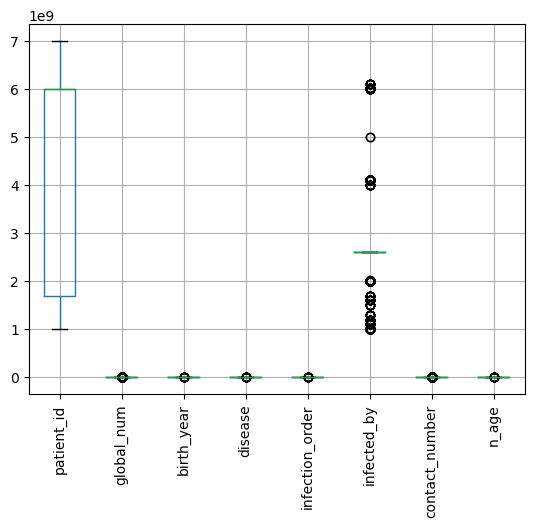

In [510]:
df.boxplot(rot=90)
    


**<font color='teal'> Create dummy features for object type features. </font>**

In [511]:
one_hot = pd.get_dummies(df[['sex', 'city', 'province', 'country', 'age', 'infection_case', 'state']])
df = df.drop(columns=['sex', 'city', 'province', 'country', 'age', 'infection_case', 'state'], axis = 1)
df = df.join(one_hot)

In [512]:
df

,patient_id,global_num,birth_year,disease,infection_order,infected_by,contact_number,n_age,sex_female,sex_male,...,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow,state_deceased,state_isolated,state_released
0,1000000001,2.0,1964.0,0,1.0,2.600789e+09,75.0,56,0,1,...,0,0,0,0,0,0,1,0,0,1
1,1000000002,5.0,1987.0,0,1.0,2.600789e+09,31.0,33,0,1,...,0,0,0,0,0,0,1,0,0,1
2,1000000003,6.0,1964.0,0,2.0,2.002000e+09,17.0,56,0,1,...,0,0,0,1,0,0,0,0,0,1
3,1000000004,7.0,1991.0,0,1.0,2.600789e+09,9.0,29,0,1,...,0,0,0,0,0,0,1,0,0,1
4,1000000005,9.0,1992.0,0,2.0,1.000000e+09,2.0,28,1,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,6100000085,4665.0,1990.0,0,2.0,2.600789e+09,24.0,30,0,1,...,0,0,0,1,0,0,0,0,1,0
2214,7000000001,139.0,1998.0,0,2.0,2.600789e+09,87.0,22,0,1,...,0,0,0,1,0,0,0,0,1,0
2215,7000000002,222.0,1998.0,0,2.0,2.600789e+09,84.0,22,1,0,...,0,0,0,1,0,0,0,0,0,1
2216,7000000003,4345.0,1972.0,0,2.0,2.600789e+09,21.0,48,1,0,...,0,0,0,1,0,0,0,0,0,1


### Split the data into test and train subsamples

In [513]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y
X = df.iloc[:, 0: -3]
y = df[['state_deceased', 'state_isolated', 'state_released']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [514]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [515]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [517]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

ValueError: multilabel-indicator is not supported

### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [518]:
class_names=['isolated','released','missing','deceased'] # name  of classes

In [520]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

ValueError: multilabel-indicator is not supported

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


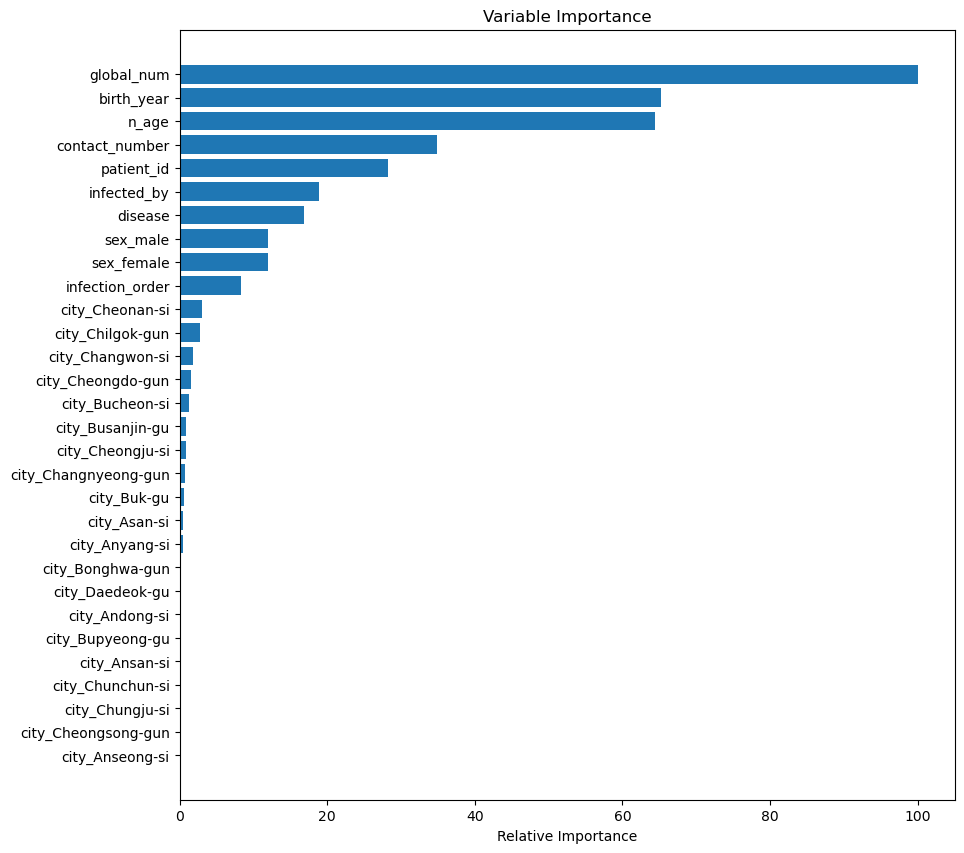

In [521]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.